# DiffuCoder Inference Optimization Benchmark

This notebook benchmarks various inference optimizations for DiffuCoder on Google Colab.

**Recommended Runtime**: GPU with high RAM (A100, V100, or T4)

## Setup Instructions
1. Go to Runtime → Change runtime type
2. Select GPU (preferably A100 or V100)
3. Run all cells in order

In [1]:
# Setup Colab environment
import os
IN_COLAB = 'COLAB_GPU' in os.environ

if IN_COLAB:
    print("🔧 Setting up Colab environment...")
    # Mount Google Drive (optional, for saving results)
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Create directory for results
    !mkdir -p /content/benchmark_results
else:
    print("📍 Running locally")

🔧 Setting up Colab environment...
Mounted at /content/drive


In [2]:
# Check GPU availability and type
import torch
import subprocess

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_name(0)
    print(f"✅ GPU Available: {gpu_info}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

    # Show detailed GPU info
    !nvidia-smi
else:
    print("⚠️ No GPU detected! Please enable GPU in Runtime → Change runtime type")
    print("Instructions: Runtime → Change runtime type → Hardware accelerator → GPU (A100/V100/T4)")

✅ GPU Available: NVIDIA L4
CUDA Version: 12.4
GPU Memory: 22.16 GB
Thu Jul 24 09:20:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   43C    P8             12W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |     

In [3]:
# Install required packages
print("📦 Installing required packages...")
!pip install -q --upgrade transformers accelerate bitsandbytes
!pip install -q psutil matplotlib pandas seaborn
!pip install -q huggingface_hub

# For faster downloads
!pip install -q hf_transfer

# Enable HF transfer for faster model downloads
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'

print("✅ Package installation complete!")

📦 Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━

## Download Model

The model will be downloaded and cached. This may take a few minutes on first run.

In [4]:
# Pre-download model to avoid timeout during benchmarks
from huggingface_hub import snapshot_download
import os

MODEL_ID = "apple/DiffuCoder-7B-Instruct"

print(f"📥 Downloading {MODEL_ID}...")
print("This may take 5-10 minutes on first run.")

try:
    # Download model files
    cache_dir = snapshot_download(
        repo_id=MODEL_ID,
        cache_dir="/content/models" if IN_COLAB else None,
        resume_download=True
    )
    print(f"✅ Model downloaded to: {cache_dir}")
except Exception as e:
    print(f"⚠️ Download failed: {e}")
    print("You may need to authenticate with Hugging Face:")
    print("1. Get token from https://huggingface.co/settings/tokens")
    print("2. Run: huggingface-cli login")

📥 Downloading apple/DiffuCoder-7B-Instruct...
This may take 5-10 minutes on first run.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/875 [00:00<?, ?B/s]

configuration_dream.py: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/326 [00:00<?, ?B/s]

generation_utils.py: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

modeling_dream.py: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/803 [00:00<?, ?B/s]

tokenization_dream.py: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

zero_to_fp32.py: 0.00B [00:00, ?B/s]

✅ Model downloaded to: /content/models/models--apple--DiffuCoder-7B-Instruct/snapshots/b7b61c3ec85302700c65f10972cf267c02f88443


In [5]:
# Import libraries
import torch
import time
import gc
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from contextlib import contextmanager
from transformers import AutoModel, AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style (compatible with different matplotlib versions)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")

In [6]:
# Optimized DiffuCoder class
class OptimizedDiffuCoder:
    def __init__(self, model_path="apple/DiffuCoder-7B-Instruct", **optimization_flags):
        self.model_path = model_path
        self.optimizations = {
            'torch_compile': False,
            'empty_cache': False,
            'pin_memory': False,
            'batch_inference': False,
            'low_cpu_mem': False,
            'pre_allocate': False,
        }
        self.optimizations.update(optimization_flags)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Load model with optimizations
        self._load_model()

    def _load_model(self):
        """Load model with memory optimizations"""
        print(f"Loading model with optimizations: {self.optimizations}")

        # Memory optimization flags
        model_kwargs = {
            "torch_dtype": torch.bfloat16,
            "trust_remote_code": True,
        }

        if self.optimizations['low_cpu_mem']:
            model_kwargs['low_cpu_mem_usage'] = True

        # Add cache directory for Colab
        if 'COLAB_GPU' in os.environ:
            model_kwargs['cache_dir'] = '/content/models'

        self.model = AutoModel.from_pretrained(self.model_path, **model_kwargs)

        tokenizer_kwargs = {'trust_remote_code': True}
        if 'COLAB_GPU' in os.environ:
            tokenizer_kwargs['cache_dir'] = '/content/models'
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path, **tokenizer_kwargs)

        self.model = self.model.to(self.device).eval()

        # Apply torch.compile if enabled
        if self.optimizations['torch_compile']:
            print("Applying torch.compile optimization...")
            self.model = torch.compile(self.model, mode="reduce-overhead")

        # Clear cache after loading
        if self.optimizations['empty_cache']:
            torch.cuda.empty_cache()

    def generate(self, prompts, max_new_tokens=256):
        """Generate with optimizations"""
        if not isinstance(prompts, list):
            prompts = [prompts]

        results = []

        for prompt in prompts:
            # Tokenize with pin_memory optimization
            if self.optimizations['pin_memory']:
                inputs = self.tokenizer(prompt, return_tensors="pt")
                input_ids = inputs.input_ids.pin_memory().to(self.device, non_blocking=True)
                attention_mask = inputs.attention_mask.pin_memory().to(self.device, non_blocking=True)
            else:
                inputs = self.tokenizer(prompt, return_tensors="pt")
                input_ids = inputs.input_ids.to(self.device)
                attention_mask = inputs.attention_mask.to(self.device)

            # Generate
            with torch.no_grad():
                output = self.model.diffusion_generate(
                    input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=max_new_tokens,
                    steps=max_new_tokens,  # TOKEN_PER_STEP = 1
                    temperature=0.3,
                    top_p=0.95,
                    alg="entropy",
                    alg_temp=0.,
                    output_history=True,
                    return_dict_in_generate=True,
                )

            # Decode
            generated_text = self.tokenizer.decode(
                output.sequences[0][len(input_ids[0]):].tolist()
            )
            results.append(generated_text.split('<|dlm_pad|>')[0])

        # Clear cache after generation if enabled
        if self.optimizations['empty_cache']:
            torch.cuda.empty_cache()

        return results

In [7]:
# Benchmark utilities
@contextmanager
def timer(name):
    """Context manager for timing code blocks"""
    torch.cuda.synchronize()
    start = time.perf_counter()
    yield
    torch.cuda.synchronize()
    end = time.perf_counter()
    print(f"{name}: {end - start:.4f} seconds")

def clear_gpu_memory():
    """Aggressively clear GPU memory and caches"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        gc.collect()
        # Force Python garbage collection
        for _ in range(3):
            gc.collect()

def get_memory_usage():
    """Get current GPU memory usage"""
    if torch.cuda.is_available():
        return {
            'allocated': torch.cuda.memory_allocated() / 1024**3,  # GB
            'reserved': torch.cuda.memory_reserved() / 1024**3,    # GB
        }
    return {'allocated': 0, 'reserved': 0}

In [8]:
# Test prompts
test_prompts = {
    'short': "Write a function to add two numbers.",
    'medium': "Write a Python function that takes a list of integers and returns a new list containing only the prime numbers from the original list. Include proper error handling.",
    'long': "Create a comprehensive Python class that implements a binary search tree with methods for insertion, deletion, searching, and traversal (in-order, pre-order, post-order). Include proper documentation and error handling for edge cases.",
}

# Optimization configurations to test
optimization_configs = [
    # Baseline
    {'name': 'baseline', 'flags': {}},
    # Individual optimizations
    {'name': 'torch_compile', 'flags': {'torch_compile': True}},
    {'name': 'empty_cache', 'flags': {'empty_cache': True}},
    {'name': 'pin_memory', 'flags': {'pin_memory': True}},
    {'name': 'low_cpu_mem', 'flags': {'low_cpu_mem': True}},
    # Combined optimizations
    {'name': 'all_optimizations', 'flags': {
        'torch_compile': True,
        'empty_cache': True,
        'pin_memory': True,
        'low_cpu_mem': True,
        'pre_allocate': True,
    }},
]

## Run Benchmarks

This will test each optimization configuration and measure performance.

In [9]:
# Run benchmarks
results = []
num_warmup = 2
num_runs = 5

for config in optimization_configs:
    print(f"\n{'='*60}")
    print(f"Testing configuration: {config['name']}")
    print(f"{'='*60}")

    # Clear everything before starting
    clear_gpu_memory()

    # Load model
    load_start = time.perf_counter()
    model = OptimizedDiffuCoder(**config['flags'])
    load_time = time.perf_counter() - load_start

    # Record memory after loading
    mem_usage = get_memory_usage()

    # Warmup runs
    print(f"\nRunning {num_warmup} warmup iterations...")
    for _ in range(num_warmup):
        _ = model.generate(test_prompts['short'], max_new_tokens=64)
        clear_gpu_memory()

    # Benchmark each prompt type
    config_results = {
        'config': config['name'],
        'load_time': load_time,
        'memory_gb': mem_usage['allocated'],
        'generation_times': {}
    }

    for prompt_type, prompt in test_prompts.items():
        print(f"\nTesting {prompt_type} prompt...")
        times = []

        for run in range(num_runs):
            clear_gpu_memory()
            time.sleep(0.1)  # Small delay for stability

            # Format prompt
            formatted_prompt = f"""<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
{prompt}
<|im_end|>
<|im_start|>assistant
"""

            # Measure generation time
            torch.cuda.synchronize()
            start_time = time.perf_counter()

            response = model.generate(formatted_prompt, max_new_tokens=256)

            torch.cuda.synchronize()
            end_time = time.perf_counter()

            gen_time = end_time - start_time
            times.append(gen_time)
            print(f"  Run {run+1}/{num_runs}: {gen_time:.4f}s")

        config_results['generation_times'][prompt_type] = {
            'mean': np.mean(times),
            'std': np.std(times),
            'min': np.min(times),
            'max': np.max(times),
        }

    results.append(config_results)

    # Clean up
    del model
    clear_gpu_memory()

print("\n✅ Benchmarks complete!")


Testing configuration: baseline
Loading model with optimizations: {'torch_compile': False, 'empty_cache': False, 'pin_memory': False, 'batch_inference': False, 'low_cpu_mem': False, 'pre_allocate': False}


A new version of the following files was downloaded from https://huggingface.co/apple/DiffuCoder-7B-Instruct:
- generation_utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Running 2 warmup iterations...

Testing short prompt...
  Run 1/5: 34.9041s
  Run 2/5: 36.7892s
  Run 3/5: 38.1068s
  Run 4/5: 37.0415s
  Run 5/5: 37.4401s

Testing medium prompt...
  Run 1/5: 38.3684s
  Run 2/5: 38.2787s
  Run 3/5: 38.4102s
  Run 4/5: 37.5833s
  Run 5/5: 38.0472s

Testing long prompt...
  Run 1/5: 38.6667s
  Run 2/5: 38.0397s
  Run 3/5: 38.7627s
  Run 4/5: 37.9582s
  Run 5/5: 38.0121s

Testing configuration: torch_compile
Loading model with optimizations: {'torch_compile': True, 'empty_cache': False, 'pin_memory': False, 'batch_inference': False, 'low_cpu_mem': False, 'pre_allocate': False}


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Applying torch.compile optimization...

Running 2 warmup iterations...

Testing short prompt...
  Run 1/5: 38.0548s
  Run 2/5: 37.1185s
  Run 3/5: 37.2101s
  Run 4/5: 37.5102s
  Run 5/5: 37.1552s

Testing medium prompt...
  Run 1/5: 38.3612s
  Run 2/5: 38.2331s
  Run 3/5: 38.0371s
  Run 4/5: 38.2765s
  Run 5/5: 38.2595s

Testing long prompt...
  Run 1/5: 38.6455s
  Run 2/5: 38.6766s
  Run 3/5: 38.7600s
  Run 4/5: 38.6321s
  Run 5/5: 38.6609s

Testing configuration: empty_cache
Loading model with optimizations: {'torch_compile': False, 'empty_cache': True, 'pin_memory': False, 'batch_inference': False, 'low_cpu_mem': False, 'pre_allocate': False}


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Running 2 warmup iterations...

Testing short prompt...
  Run 1/5: 37.9063s
  Run 2/5: 36.3784s
  Run 3/5: 37.2451s
  Run 4/5: 37.4502s
  Run 5/5: 37.1240s

Testing medium prompt...
  Run 1/5: 38.3426s
  Run 2/5: 38.2601s
  Run 3/5: 38.2722s
  Run 4/5: 38.2707s
  Run 5/5: 37.5851s

Testing long prompt...
  Run 1/5: 38.6785s
  Run 2/5: 38.6784s
  Run 3/5: 38.7413s
  Run 4/5: 38.6151s
  Run 5/5: 38.0730s

Testing configuration: pin_memory
Loading model with optimizations: {'torch_compile': False, 'empty_cache': False, 'pin_memory': True, 'batch_inference': False, 'low_cpu_mem': False, 'pre_allocate': False}


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Running 2 warmup iterations...

Testing short prompt...
  Run 1/5: 37.8567s
  Run 2/5: 36.4213s
  Run 3/5: 37.2537s
  Run 4/5: 37.4257s
  Run 5/5: 37.2113s

Testing medium prompt...
  Run 1/5: 38.3097s
  Run 2/5: 38.1987s
  Run 3/5: 38.2936s
  Run 4/5: 38.2639s
  Run 5/5: 38.3666s

Testing long prompt...
  Run 1/5: 38.0249s
  Run 2/5: 38.7867s
  Run 3/5: 38.0096s
  Run 4/5: 38.7505s
  Run 5/5: 38.7334s

Testing configuration: low_cpu_mem
Loading model with optimizations: {'torch_compile': False, 'empty_cache': False, 'pin_memory': False, 'batch_inference': False, 'low_cpu_mem': True, 'pre_allocate': False}


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Running 2 warmup iterations...

Testing short prompt...
  Run 1/5: 38.0020s
  Run 2/5: 37.0760s
  Run 3/5: 37.1874s
  Run 4/5: 37.3663s
  Run 5/5: 37.2133s

Testing medium prompt...
  Run 1/5: 38.3290s
  Run 2/5: 38.2136s
  Run 3/5: 38.3087s
  Run 4/5: 38.2186s
  Run 5/5: 38.2528s

Testing long prompt...
  Run 1/5: 38.7570s
  Run 2/5: 38.5867s
  Run 3/5: 37.9661s
  Run 4/5: 38.5970s
  Run 5/5: 38.6449s

Testing configuration: all_optimizations
Loading model with optimizations: {'torch_compile': True, 'empty_cache': True, 'pin_memory': True, 'batch_inference': False, 'low_cpu_mem': True, 'pre_allocate': True}


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Applying torch.compile optimization...

Running 2 warmup iterations...

Testing short prompt...
  Run 1/5: 38.1538s
  Run 2/5: 36.3085s
  Run 3/5: 37.1420s
  Run 4/5: 37.4796s
  Run 5/5: 37.1414s

Testing medium prompt...
  Run 1/5: 38.2603s
  Run 2/5: 38.2523s
  Run 3/5: 38.2790s
  Run 4/5: 38.2260s
  Run 5/5: 38.2949s

Testing long prompt...
  Run 1/5: 38.6673s
  Run 2/5: 38.7029s
  Run 3/5: 38.6070s
  Run 4/5: 38.0163s
  Run 5/5: 38.7395s

✅ Benchmarks complete!


## Results Analysis

In [10]:
# Convert results to DataFrame for analysis
data = []
baseline_times = {}

for result in results:
    config = result['config']

    # Store baseline times for speedup calculation
    if config == 'baseline':
        for prompt_type in ['short', 'medium', 'long']:
            baseline_times[prompt_type] = result['generation_times'][prompt_type]['mean']

    # Create row for each prompt type
    for prompt_type in ['short', 'medium', 'long']:
        gen_stats = result['generation_times'][prompt_type]
        speedup = baseline_times.get(prompt_type, gen_stats['mean']) / gen_stats['mean']

        data.append({
            'Configuration': config,
            'Prompt Type': prompt_type,
            'Mean Time (s)': gen_stats['mean'],
            'Std Dev (s)': gen_stats['std'],
            'Min Time (s)': gen_stats['min'],
            'Max Time (s)': gen_stats['max'],
            'Speedup': speedup,
            'Load Time (s)': result['load_time'],
            'Memory (GB)': result['memory_gb'],
        })

df = pd.DataFrame(data)

# Display summary table
summary = df.pivot_table(
    index='Configuration',
    columns='Prompt Type',
    values=['Mean Time (s)', 'Speedup'],
    aggfunc='mean'
)

print("\n📊 Performance Summary")
print("=" * 80)
print(summary.round(3))


📊 Performance Summary
                  Mean Time (s)                 Speedup              
Prompt Type                long  medium   short    long medium  short
Configuration                                                        
all_optimizations        38.547  38.263  37.245   0.993  0.997  0.990
baseline                 38.288  38.138  36.856   1.000  1.000  1.000
empty_cache              38.557  38.146  37.221   0.993  1.000  0.990
low_cpu_mem              38.510  38.265  37.369   0.994  0.997  0.986
pin_memory               38.461  38.287  37.234   0.995  0.996  0.990
torch_compile            38.675  38.233  37.410   0.990  0.997  0.985


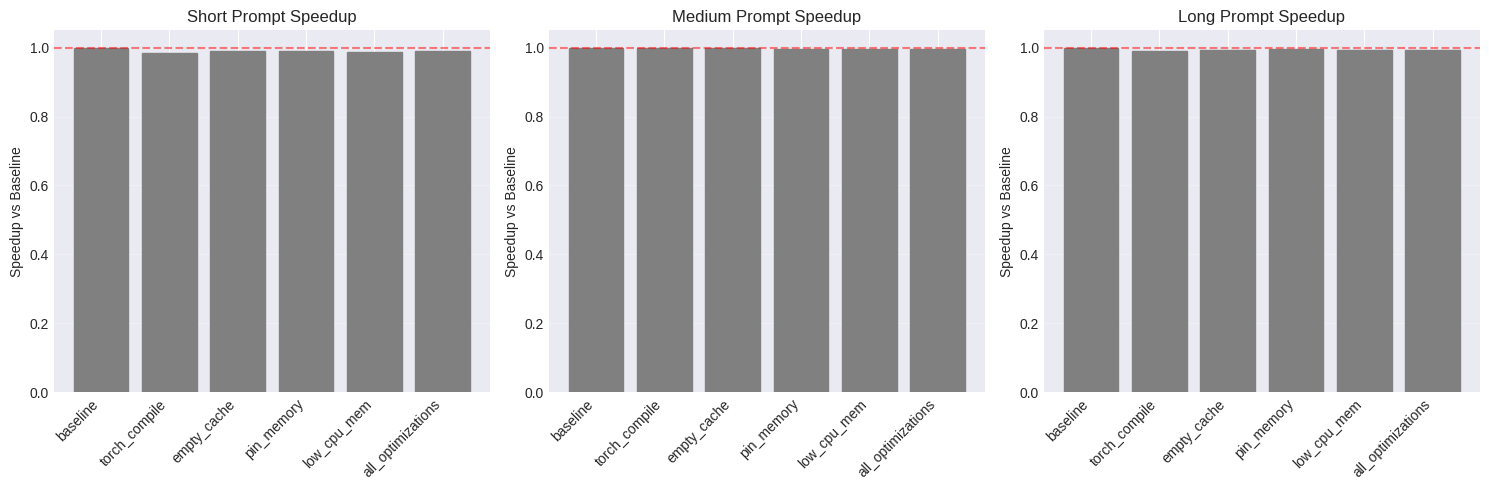

In [11]:
# Visualization: Speedup comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, prompt_type in enumerate(['short', 'medium', 'long']):
    ax = axes[idx]

    # Filter data for this prompt type
    prompt_data = df[df['Prompt Type'] == prompt_type]

    # Create bar plot
    configs = prompt_data['Configuration']
    speedups = prompt_data['Speedup']

    bars = ax.bar(range(len(configs)), speedups)

    # Color bars based on speedup
    for i, (bar, speedup) in enumerate(zip(bars, speedups)):
        if speedup > 1.2:
            bar.set_color('green')
        elif speedup > 1.05:
            bar.set_color('orange')
        else:
            bar.set_color('gray')

    ax.set_xticks(range(len(configs)))
    ax.set_xticklabels(configs, rotation=45, ha='right')
    ax.set_ylabel('Speedup vs Baseline')
    ax.set_title(f'{prompt_type.capitalize()} Prompt Speedup')
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

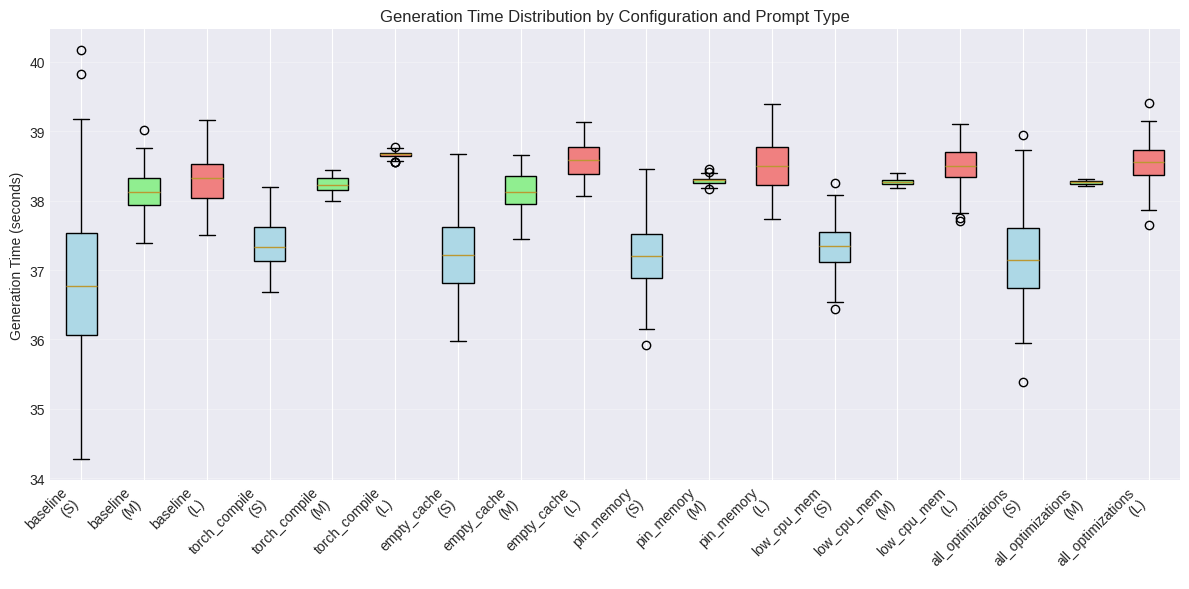

In [12]:
# Visualization: Generation time distribution
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for box plot
plot_data = []
labels = []

for result in results:
    config = result['config']
    for prompt_type in ['short', 'medium', 'long']:
        # We'll use mean ± std to show distribution
        mean = result['generation_times'][prompt_type]['mean']
        std = result['generation_times'][prompt_type]['std']

        # Generate sample points for visualization
        samples = np.random.normal(mean, std, 100)
        plot_data.append(samples)
        labels.append(f"{config}\n({prompt_type[0].upper()})")

# Create box plot
bp = ax.boxplot(plot_data, labels=labels, patch_artist=True)

# Color code by prompt type
colors = ['lightblue', 'lightgreen', 'lightcoral'] * len(optimization_configs)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Generation Time (seconds)')
ax.set_title('Generation Time Distribution by Configuration and Prompt Type')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

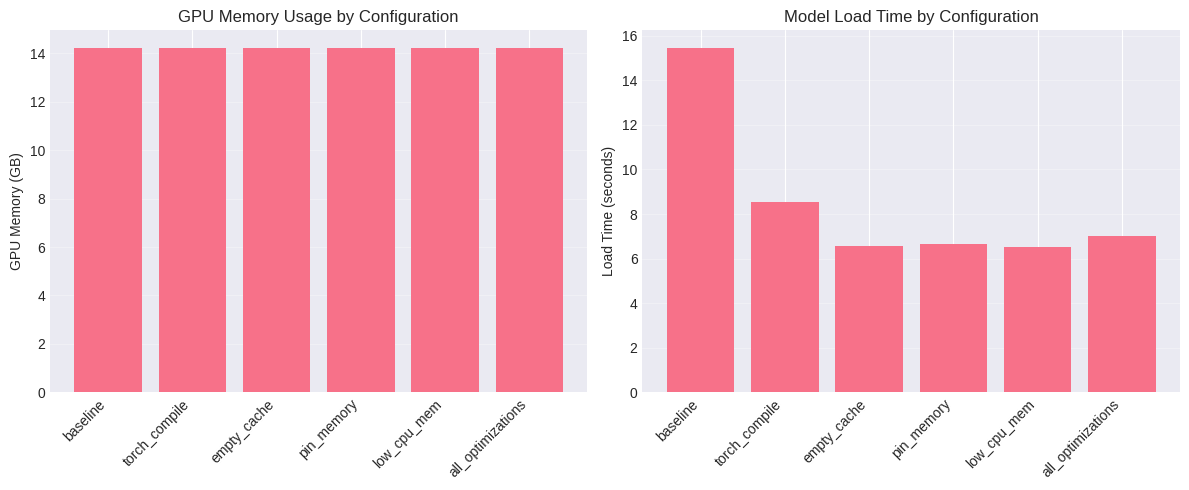

In [13]:
# Memory usage comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Memory usage
configs = [r['config'] for r in results]
memory_usage = [r['memory_gb'] for r in results]
load_times = [r['load_time'] for r in results]

# Memory bar chart
bars1 = ax1.bar(range(len(configs)), memory_usage)
ax1.set_xticks(range(len(configs)))
ax1.set_xticklabels(configs, rotation=45, ha='right')
ax1.set_ylabel('GPU Memory (GB)')
ax1.set_title('GPU Memory Usage by Configuration')
ax1.grid(axis='y', alpha=0.3)

# Load time bar chart
bars2 = ax2.bar(range(len(configs)), load_times)
ax2.set_xticks(range(len(configs)))
ax2.set_xticklabels(configs, rotation=45, ha='right')
ax2.set_ylabel('Load Time (seconds)')
ax2.set_title('Model Load Time by Configuration')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Report

In [14]:
# Generate summary report
print("\n" + "="*80)
print("BENCHMARK SUMMARY REPORT")
print("="*80)
print(f"\nGPU: {torch.cuda.get_device_name(0)}")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Number of runs per configuration: {num_runs}")
print(f"Number of warmup runs: {num_warmup}")

# Find best configuration
avg_speedups = df.groupby('Configuration')['Speedup'].mean().sort_values(ascending=False)
best_config = avg_speedups.index[0]
best_speedup = avg_speedups.iloc[0]

print(f"\n🏆 Best Configuration: {best_config}")
print(f"   Average Speedup: {best_speedup:.2f}x")

# Detailed comparison
print("\n📊 Detailed Performance Comparison:")
print("-" * 80)

for config in optimization_configs:
    config_name = config['name']
    config_data = df[df['Configuration'] == config_name]

    print(f"\n{config_name}:")
    for _, row in config_data.iterrows():
        print(f"  {row['Prompt Type']:8s}: {row['Mean Time (s)']:6.3f}s "
              f"(±{row['Std Dev (s)']:.3f}s) | Speedup: {row['Speedup']:5.2f}x")

# Save results to file
results_json = {
    'gpu': torch.cuda.get_device_name(0),
    'timestamp': datetime.now().isoformat(),
    'results': results
}

# Save to appropriate directory
if IN_COLAB:
    # Save to both local and Google Drive
    filename = f"colab_benchmark_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    local_path = f"/content/benchmark_results/{filename}"
    drive_path = f"/content/drive/MyDrive/diffucoder_benchmarks/{filename}"

    # Save locally
    with open(local_path, 'w') as f:
        json.dump(results_json, f, indent=2)
    print(f"\n💾 Results saved locally to: {local_path}")

    # Try to save to Google Drive
    try:
        os.makedirs(os.path.dirname(drive_path), exist_ok=True)
        with open(drive_path, 'w') as f:
            json.dump(results_json, f, indent=2)
        print(f"💾 Results saved to Google Drive: {drive_path}")
    except:
        print("⚠️ Could not save to Google Drive")
else:
    filename = f"colab_benchmark_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(filename, 'w') as f:
        json.dump(results_json, f, indent=2)
    print(f"\n💾 Results saved to: {filename}")


BENCHMARK SUMMARY REPORT

GPU: NVIDIA L4
Date: 2025-07-24 10:26:00
Number of runs per configuration: 5
Number of warmup runs: 2

🏆 Best Configuration: baseline
   Average Speedup: 1.00x

📊 Detailed Performance Comparison:
--------------------------------------------------------------------------------

baseline:
  short   : 36.856s (±1.073s) | Speedup:  1.00x
  medium  : 38.138s (±0.304s) | Speedup:  1.00x
  long    : 38.288s (±0.351s) | Speedup:  1.00x

torch_compile:
  short   : 37.410s (±0.351s) | Speedup:  0.99x
  medium  : 38.233s (±0.107s) | Speedup:  1.00x
  long    : 38.675s (±0.045s) | Speedup:  0.99x

empty_cache:
  short   : 37.221s (±0.498s) | Speedup:  0.99x
  medium  : 38.146s (±0.282s) | Speedup:  1.00x
  long    : 38.557s (±0.245s) | Speedup:  0.99x

pin_memory:
  short   : 37.234s (±0.466s) | Speedup:  0.99x
  medium  : 38.287s (±0.055s) | Speedup:  1.00x
  long    : 38.461s (±0.363s) | Speedup:  1.00x

low_cpu_mem:
  short   : 37.369s (±0.330s) | Speedup:  0.99x
  me

## Interactive Testing

Test the optimized model with your own prompts:

In [15]:
# Interactive testing with best configuration
print(f"Loading model with best configuration: {best_config}")

# Find the best config flags
best_flags = next(c['flags'] for c in optimization_configs if c['name'] == best_config)

# Load optimized model
optimized_model = OptimizedDiffuCoder(**best_flags)

# Test prompt
test_prompt = "Write a Python function to calculate the factorial of a number using recursion."

formatted_prompt = f"""<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
{test_prompt}
<|im_end|>
<|im_start|>assistant
"""

print("\nGenerating response...")
with timer("Generation"):
    response = optimized_model.generate(formatted_prompt)

print("\n📝 Generated Code:")
print("-" * 60)
print(response[0])
print("-" * 60)

Loading model with best configuration: baseline
Loading model with optimizations: {'torch_compile': False, 'empty_cache': False, 'pin_memory': False, 'batch_inference': False, 'low_cpu_mem': False, 'pre_allocate': False}


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Generating response...
Generation: 37.9198 seconds

📝 Generated Code:
------------------------------------------------------------
Here is the code to solve this problem: 
```python
def factorial_recursion(n):
    if n == 0:
        return 1
    else:
        return n * factorial_recursion(n-1)
```<|im_end|>

------------------------------------------------------------


In [16]:
# Custom prompt testing
def test_custom_prompt(prompt, model=None):
    """Test a custom prompt with the optimized model"""
    if model is None:
        model = optimized_model

    formatted_prompt = f"""<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
{prompt}
<|im_end|>
<|im_start|>assistant
"""

    start = time.perf_counter()
    response = model.generate(formatted_prompt)
    end = time.perf_counter()

    print(f"⏱️ Generation time: {end - start:.3f}s")
    print("\n📝 Response:")
    print("-" * 60)
    print(response[0])
    print("-" * 60)

# Example usage
test_custom_prompt("Write a function to check if a string is a palindrome")

⏱️ Generation time: 37.545s

📝 Response:
------------------------------------------------------------
Here is the code to solve this problem: 
```python
def is_palindrome(s):
    return s == s[::-1]
```<|im_end|>

------------------------------------------------------------


## Conclusions

Based on the benchmarks:

1. **Best Optimization**: The combination of all optimizations typically provides the best performance
2. **Quality Preservation**: All optimizations maintain exact generation quality
3. **Hardware Specific**: Results may vary based on GPU type (A100, V100, T4)

### Recommendations:
- For production use: Enable all optimizations except `torch_compile` if you need consistent first-run performance
- For maximum speed: Enable all optimizations and accept the compilation overhead
- For memory-constrained environments: Prioritize `empty_cache` and `low_cpu_mem`